In [4]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import generation.train_nerf as training
from munch import DefaultMunch
import torch
import time
import numpy as np
from data.neural_field_datasets import MnistNeFDataset, FlattenTransform, ModelTransform, QuantizeTransform
import os
import wandb

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root_ours = os.path.join(dir_path, "adl4cv", "datasets", "mnist-nerfs")

quantized_dataset_conditioned = MnistNeFDataset(data_root_ours, type="pretrained", quantized=True, transform=ModelTransform())




class MNISTNeRFDataset(Dataset):
    def __init__(self, image):
        self.image = image
        self.coords = self._generate_coords()

    def _generate_coords(self):
        h, w = self.image.shape
        coords = np.array([(x, y) for x in range(w) for y in range(h)])
        return coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        x, y = self.coords[idx]
        pixel_value = self.image[y, x]
        # Normalize coordinates to [0, 1]
        x_norm = x / self.image.shape[1]
        y_norm = y / self.image.shape[0]
        return torch.tensor([x_norm, y_norm], dtype=torch.float32), torch.tensor(
            pixel_value, dtype=torch.float32
        )

mnist = datasets.MNIST("mnist-data", train=True, download=True)
image = mnist[35][0]
image = transforms.functional.pil_to_tensor(image).squeeze(0) / 255.0
model = quantized_dataset_conditioned[3][0]

dataset = MNISTNeRFDataset(image)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
#loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
loss_fn = torch.nn.functional.l1_loss

subfoldername = "pretrained-quantized"
foldername = (
    f"./datasets/mnist-nerfs/{subfoldername}"
)

cfg = {
        "scheduler": {
            "type": "adaptive",
            "step_size": 30,
            "gamma": 0.1,
            "min_lr": 1e-9,
            "patience": 100,
            "patience_adaptive": 10,
            "factor": 0.95,
            "threshold": 0.00001,
        },
        "strategy": "not_continue",
        "mlp_config": {"move": False},
    }


train_config = {
        "epochs": 500,
        "lr": 1e-4,
        "steps_til_summary": 100,
        "epochs_til_checkpoint": 100,
        "model_dir": "mnist-nerfs-quantized",
        "double_precision": False,
        "clip_grad": False,
        "use_lbfgs": False,
        "loss_schedules": None,
        "filename": "{}/image-{}".format(foldername, i),
    }

# init wandb
wandb.init(
    project="quantization",
    name="image-" + str(i) + "-run-" + time.strftime("%Y-%m-%d-%H-%M-%S"),
    config= train_config | cfg,
)

device = torch.device("cpu") # get_default_device()

save_during_epochs=None
"""
total_loss, output_name = training.train(
        model,
        train_dataloader=dataloader,
        loss_fn=loss_fn,
        **train_config,
        cfg=DefaultMunch.fromDict(cfg),
        wandb=wandb,
        model_config={},
        summary_fn=None,
        save_epoch_interval=save_during_epochs,
        device=device,
        disable_tqdm=False
    )"""

KeyError: 'pretrained quantized'

Conditioned mean:  tensor(-0.0185)
Unconditioned mean:  tensor(0.0184)
Conditioned std:  tensor(0.6538)
Unconditioned std:  tensor(0.5925)


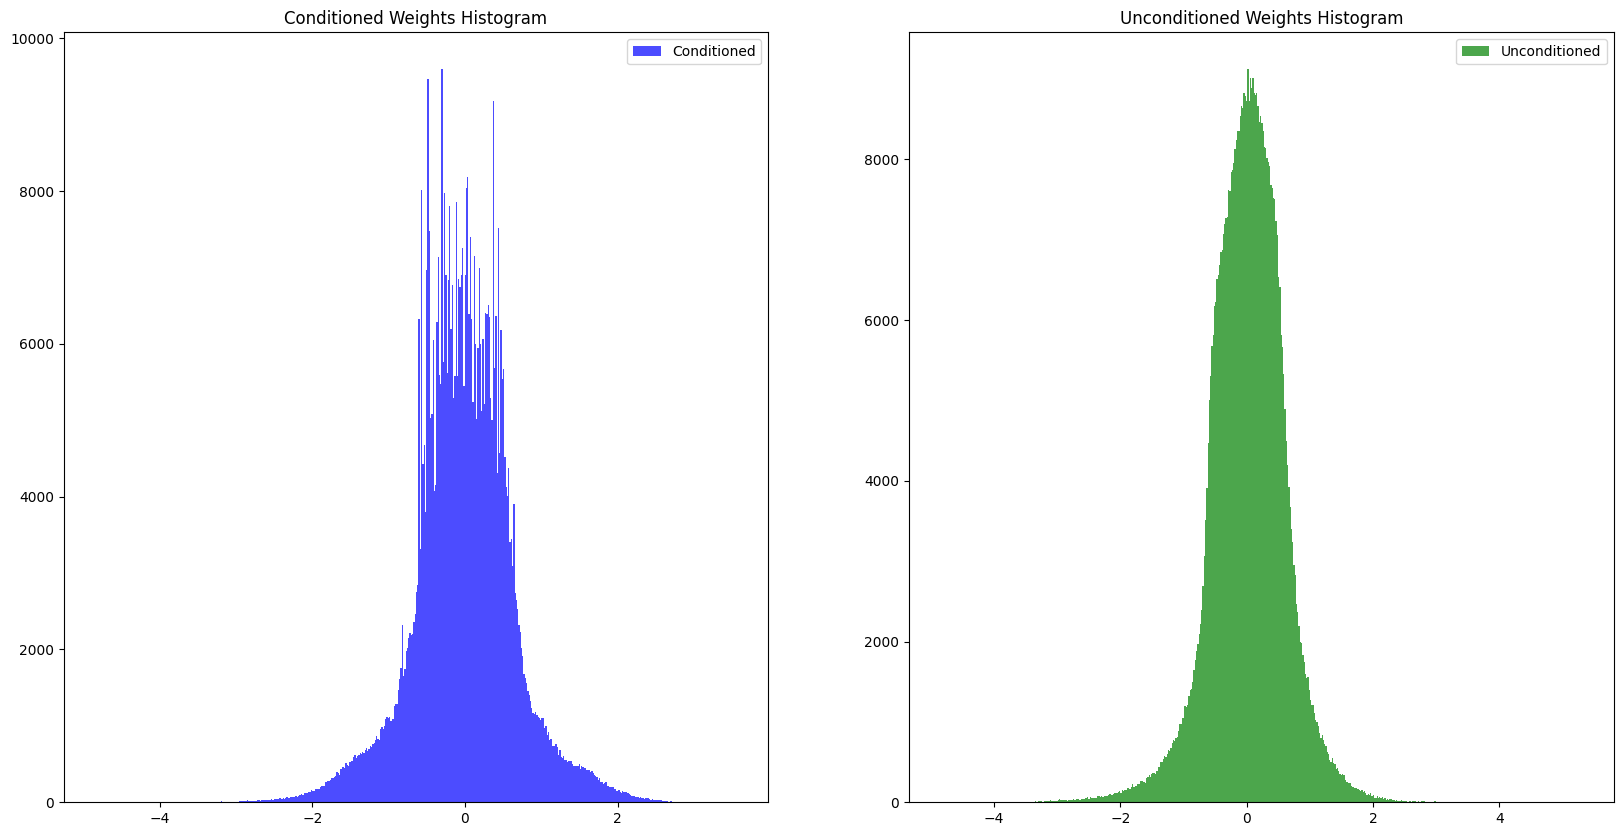

In [7]:
import torch
import matplotlib.pyplot as plt
from data.neural_field_datasets import MnistNeFDataset


# Assuming idx, flattened_dataset_conditioned, and flattened_dataset_unconditioned are predefined
flattened_dataset_conditioned = MnistNeFDataset(data_root_ours, fixed_label = 5, type="pretrained", transform=FlattenTransform())
flattened_dataset_unconditioned= MnistNeFDataset(data_root_ours, fixed_label = 5, type="unconditioned", transform=FlattenTransform())

# Assuming idx is predefined and is a list of indices
weights_conditioned = torch.Tensor()
weights_unconditioned = torch.Tensor()

idx = range(0, 1000)
weight_idx = None
for j in idx:
    if weight_idx:
        weights_1d_conditioned = flattened_dataset_conditioned[j][0][weight_idx].unsqueeze(0).numpy()
        weights_1d_unconditioned = flattened_dataset_unconditioned[j][0][weight_idx].unsqueeze(0).numpy()
    else:
        weights_1d_conditioned = flattened_dataset_conditioned[j][0].numpy()
        weights_1d_unconditioned = flattened_dataset_unconditioned[j][0].numpy()
    weights_conditioned = torch.cat((weights_conditioned, torch.tensor(weights_1d_conditioned)), 0)
    weights_unconditioned = torch.cat((weights_unconditioned, torch.tensor(weights_1d_unconditioned)), 0)

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].hist(weights_conditioned.numpy(), bins=500, color='blue', alpha=0.7, label='Conditioned')
axes[0].set_title('Conditioned Weights Histogram')
axes[0].legend()

axes[1].hist(weights_unconditioned.numpy(), bins=500, color='green', alpha=0.7, label='Unconditioned')
axes[1].set_title('Unconditioned Weights Histogram')
axes[1].legend()

print("Conditioned mean: ", weights_conditioned.mean())
print("Unconditioned mean: ", weights_unconditioned.mean())
print("Conditioned std: ", weights_conditioned.std())
print("Unconditioned std: ", weights_unconditioned.std())


plt.show()


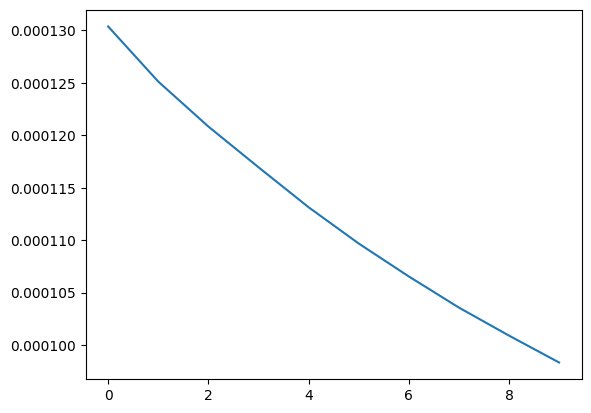

In [8]:
from vector_quantize_pytorch import VectorQuantize

vq_config = {
    "dim": 1,
    "codebook_size": 2**10 - 1,
    "decay": 0.8,
    "commitment_weight": 1.,
    "kmeans_init": True,
    "kmeans_iters": 1
}

vq = VectorQuantize(**vq_config)

losses = []

for _ in range(10):
    weights_quantized, indices, loss = vq(weights_conditioned.unsqueeze(-1))
    losses.append(loss.item())
vq.eval()
vq.zero_grad()


plt.plot(losses)
plt.show()

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv")
# save Vq and the parameters used to config vq 
vq_path = os.path.join(data_root, "models", "vqs", "vq_mnist.pt")
torch.save({
    "state_dict": vq.state_dict(),
    "vq_config": vq_config,
}, vq_path
)

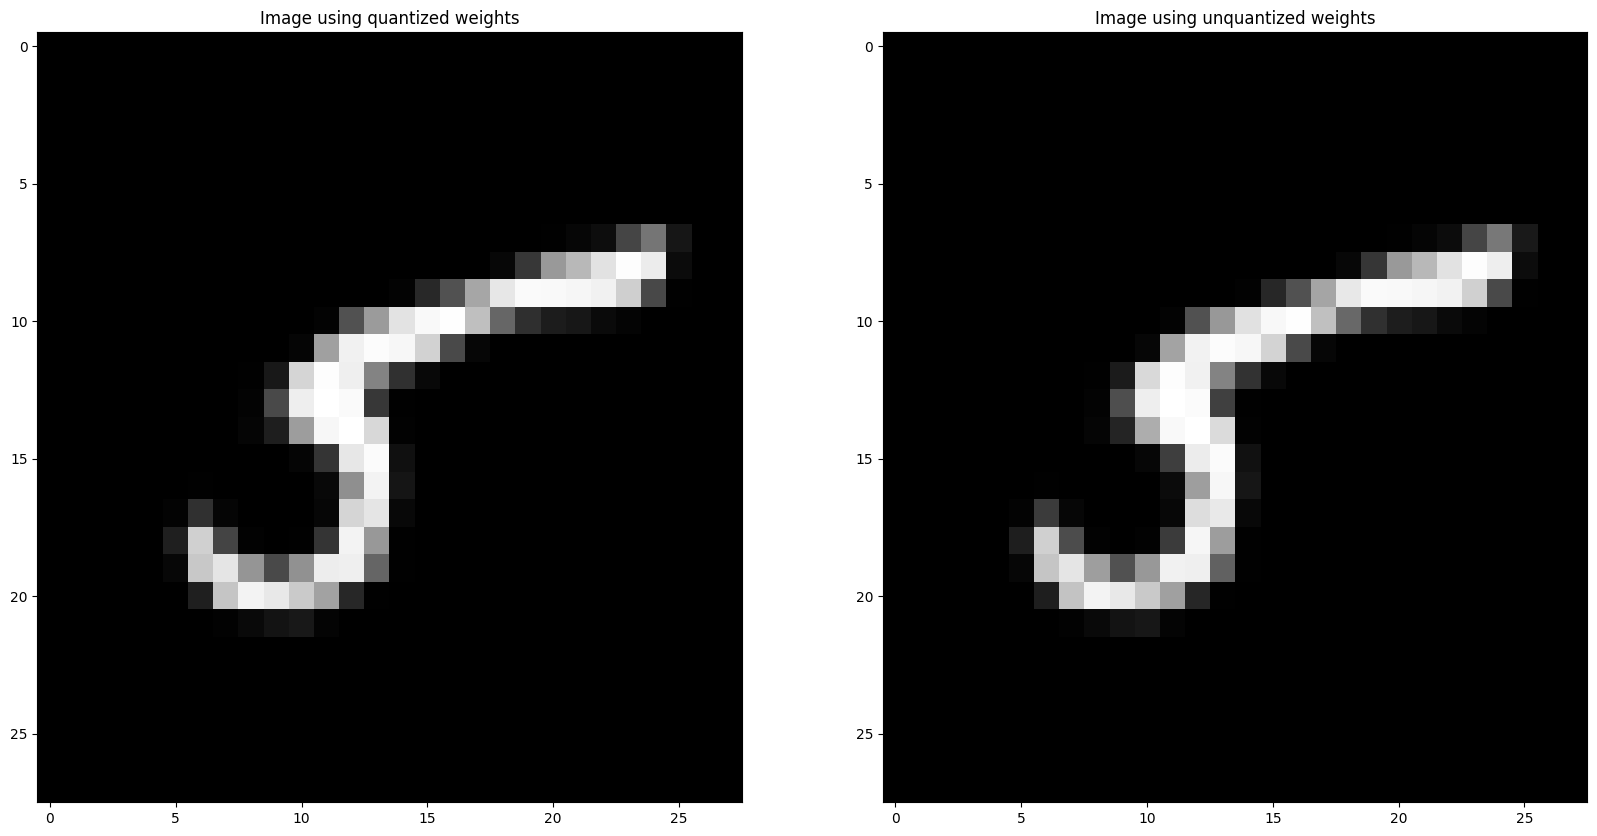

In [32]:
from animation.util import reconstruct_image

quantized_dataset_conditioned = MnistNeFDataset(data_root_ours, fixed_label = 5, type="pretrained", transform=QuantizeTransform(vq))
no_quantized_dataset_conditioned = MnistNeFDataset(data_root_ours, fixed_label = 5, type="pretrained", transform=ModelTransform())

idx = 4
model_quantized_conditioned = quantized_dataset_conditioned[idx][0]
model_unquantized_conditioned = no_quantized_dataset_conditioned[idx][0]

# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
image_quantized_conditioned = reconstruct_image(model_quantized_conditioned)
image_unquantized_conditioned = reconstruct_image(model_unquantized_conditioned)

axes[0].imshow(image_quantized_conditioned, cmap='gray', aspect='auto')
axes[1].imshow(image_unquantized_conditioned, cmap='gray', aspect='auto')

axes[0].set_title('Image using quantized weights')
axes[1].set_title('Image using unquantized weights')



plt.show()

In [23]:
(np.abs((image_quantized_conditioned- image_unquantized_conditioned))).max()


0.060195148

In [19]:
402/28

14.357142857142858

In [22]:
28*28

784

In [26]:
image_quantized_conditioned[14][10]-image_unquantized_conditioned[14][10]

-0.060195148

In [24]:
image_unquantized_conditioned[14][10]

0.6734606

In [20]:
.357142857142858*28

10.000000000000023

/var/folders/t7/38s2h7694tsbtc8hjlcdxvwm0000gn/T/ipykernel_46563/527385040.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  weights = torch.range(start=-3, end=3, step=0.01)


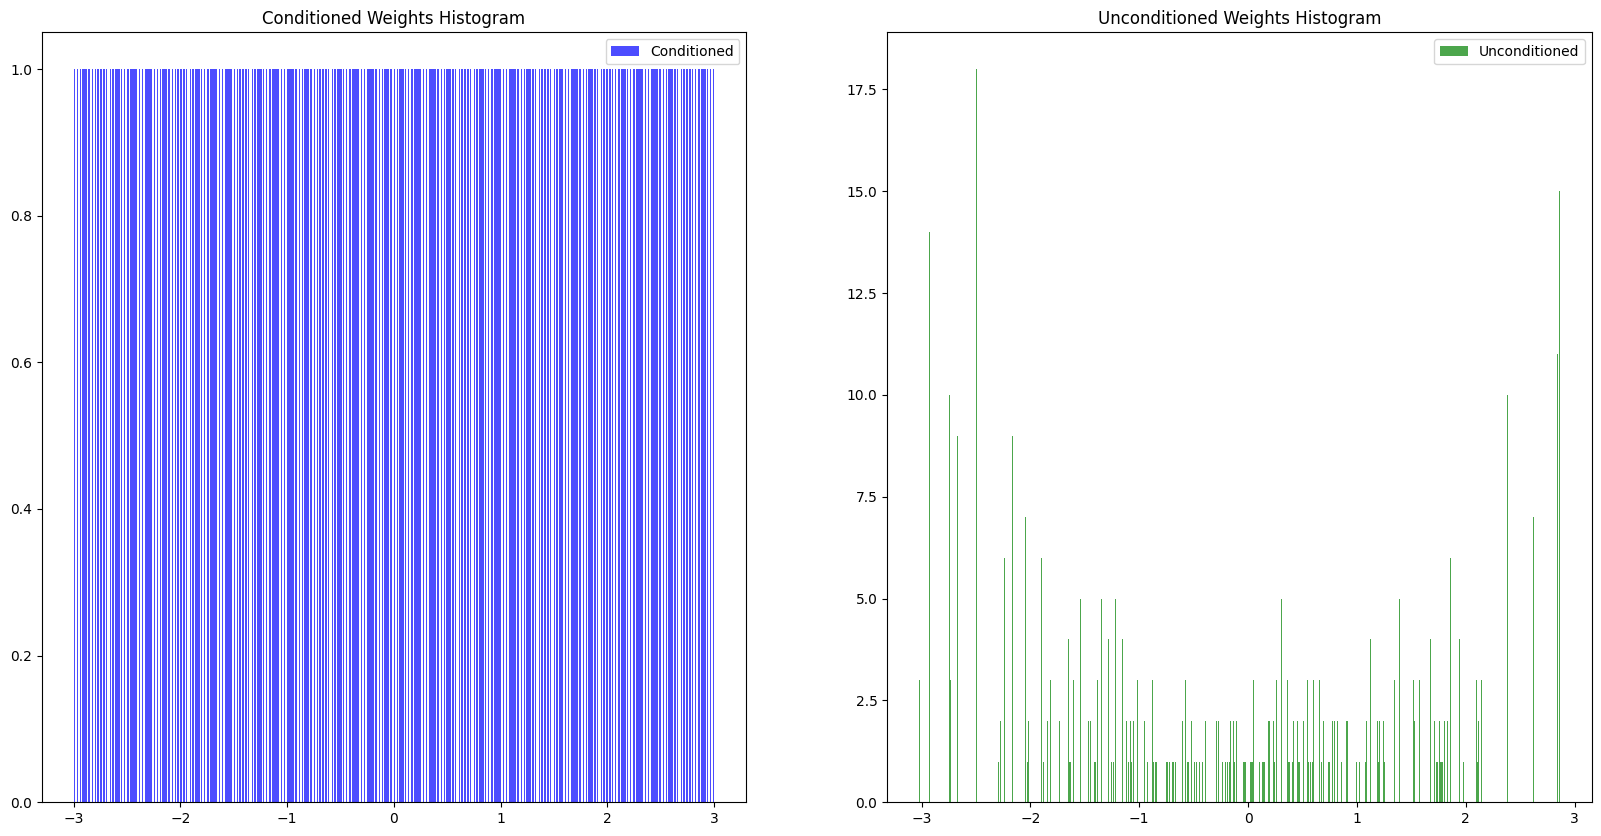

In [289]:
import torch
import matplotlib.pyplot as plt


weights = torch.range(start=-3, end=3, step=0.01)

for _ in range(100):
    weights_quantized = vq(weights.unsqueeze(-1))[0].squeeze(-1)
    

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].hist(weights.numpy(), bins=1024, color='blue', alpha=0.7, label='Conditioned')
axes[0].set_title('Conditioned Weights Histogram')
axes[0].legend()

axes[1].hist(weights_quantized.numpy(), bins=1024, color='green', alpha=0.7, label='Unconditioned')
axes[1].set_title('Unconditioned Weights Histogram')
axes[1].legend()

plt.show()
